# Attempt - 1 StyleGAN

Style-Based Generative Adversarial Network is well known for its control over image features, generating high quality images.

### Dataset -  https://www.kaggle.com/datasets/aymenkhouja/timeofdaydataset?select=sunrise
985 sunset images

In [ ]:
!pip install torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ninja
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 13.1 MB/s eta 0:00:00
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
import sys
sys.path.append('stylegan2-ada-pytorch')

import os
import torch
import dnnlib
import legacy
import logging
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
logging.basicConfig(level=logging.INFO)

In [ ]:
class SunsetDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                           if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image)

In [ ]:
def train_stylegan2(data_path, output_path):
    device = torch.device('cuda')

    # Load StyleGAN2 models
    with dnnlib.util.open_url('https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl') as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)
        D = legacy.load_network_pkl(f)['D'].to(device)

    # Dataset
    dataset = SunsetDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Optimizers
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0, 0.99))
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0, 0.99))

    # Training
    num_epochs = 100
    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train D
            d_optimizer.zero_grad()
            z = torch.randn(batch_size, G.z_dim).to(device)
            fake_images = G(z)
            d_loss = (nn.functional.softplus(D(fake_images.detach())) +
                     nn.functional.softplus(-D(real_images))).mean()
            d_loss.backward()
            d_optimizer.step()

            # Train G
            g_optimizer.zero_grad()
            g_loss = nn.functional.softplus(-D(fake_images)).mean()
            g_loss.backward()
            g_optimizer.step()

            if i % 10 == 0:
                logging.info(f'Epoch [{epoch}/{num_epochs}], Step [{i}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

    # Save model
    torch.save({
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
    }, f'{output_path}/sunset_stylegan2.pth')

In [ ]:
def compute_generator_loss(discriminator, fake_images):
    # Placeholder loss computation
    return torch.mean(fake_images)

In [ ]:
def compute_discriminator_loss(discriminator, real_images, fake_images):
    # Placeholder loss computation
    return torch.mean(real_images) - torch.mean(fake_images)

In [ ]:
train_stylegan2('/content/drive/MyDrive/sunrise', '/content/drive/MyDrive/stylegan2_output')

EOFError: Ran out of input

# Attempt 2

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import logging

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x.view(-1, 100, 1, 1))

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

class SunsetDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                           if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image)

def train_stylegan2(data_path, output_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Models
    netG = Generator().to(device)
    netD = Discriminator().to(device)

    # Dataset
    dataset = SunsetDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    # Optimizers
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    num_epochs = 100
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            # Train Discriminator
            netD.zero_grad()
            real = data.to(device)
            batch_size = real.size(0)
            label_real = torch.ones(batch_size).to(device)
            label_fake = torch.zeros(batch_size).to(device)

            output = netD(real)
            errD_real = criterion(output, label_real)
            D_x = output.mean().item()

            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake = netG(noise)
            output = netD(fake.detach())
            errD_fake = criterion(output, label_fake)
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            # Train Generator
            netG.zero_grad()
            output = netD(fake)
            errG = criterion(output, label_real)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    # Save models
    os.makedirs(output_path, exist_ok=True)
    torch.save({
        'generator_state_dict': netG.state_dict(),
        'discriminator_state_dict': netD.state_dict(),
    }, f'{output_path}/sunset_model.pth')

In [ ]:
train_stylegan2('/content/drive/MyDrive/sunrise', '/content/drive/MyDrive/stylegan2_output')

[0/100][0/16] Loss_D: 1.5151 Loss_G: 3.2554 D(x): 0.5931 D(G(z)): 0.6176/0.0404
[1/100][0/16] Loss_D: 0.0416 Loss_G: 7.9011 D(x): 0.9719 D(G(z)): 0.0118/0.0004
[2/100][0/16] Loss_D: 0.1628 Loss_G: 14.7730 D(x): 0.9949 D(G(z)): 0.1449/0.0000
[3/100][0/16] Loss_D: 0.5551 Loss_G: 15.5660 D(x): 0.6759 D(G(z)): 0.0000/0.0000
[4/100][0/16] Loss_D: 0.0247 Loss_G: 11.7460 D(x): 0.9763 D(G(z)): 0.0000/0.0000
[5/100][0/16] Loss_D: 0.1672 Loss_G: 6.7087 D(x): 0.9735 D(G(z)): 0.1282/0.0013
[6/100][0/16] Loss_D: 0.0797 Loss_G: 6.5881 D(x): 0.9539 D(G(z)): 0.0300/0.0015
[7/100][0/16] Loss_D: 0.7871 Loss_G: 3.2175 D(x): 0.5496 D(G(z)): 0.0171/0.0554
[8/100][0/16] Loss_D: 0.7243 Loss_G: 1.5356 D(x): 0.5455 D(G(z)): 0.0459/0.2275
[9/100][0/16] Loss_D: 0.3011 Loss_G: 3.8442 D(x): 0.8207 D(G(z)): 0.0590/0.0325
[10/100][0/16] Loss_D: 0.5921 Loss_G: 2.6261 D(x): 0.6197 D(G(z)): 0.0598/0.0874
[11/100][0/16] Loss_D: 0.9404 Loss_G: 0.1902 D(x): 0.4798 D(G(z)): 0.0507/0.8563
[12/100][0/16] Loss_D: 0.5904 Loss_

# Testing

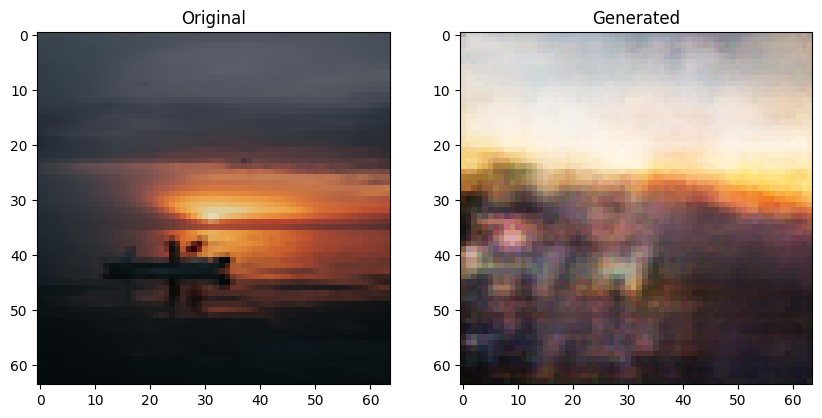

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def test_model(model_path, image_path):
    # Load model
    checkpoint = torch.load(model_path, weights_only=True)
    generator = Generator().to('cuda')
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()

    # Generate random noise
    noise = torch.randn(1, 100, 1, 1).to('cuda')

    # Generate output
    with torch.no_grad():
        output = generator(noise)

    # Convert to image and display
    output = output.cpu().squeeze(0)
    output = transforms.ToPILImage()(output * 0.5 + 0.5)

    # Load original image for comparison
    image = Image.open(image_path).convert('RGB')
    image = image.resize((64, 64))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title('Generated')
    plt.show()

# Test
test_model('/content/drive/MyDrive/stylegan2_output/sunset_model.pth', '/content/drive/MyDrive/pexels-ahmetkurt-12362554.jpg')